In [2]:
# Ensemble training (1 year of testing, 2 years of validation, the rest is training)
    # Learned weights on validation data (Constrained optimization)
    # Meta-learning using an other ML model

# Models used:
# - XGBoost
# - Neural Network
# - Logistic Regression
# - LSTM


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os


In [2]:
# Set up paths and load data
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)
print(parent_dir)

interpolated_dir = os.path.join(parent_dir, "dataset_interpolated_fixed")
# features = ["game_completed", "relative_strength", "score_difference", "type.id", "home_has_possession", "end.down", "end.yardsToEndzone", "end.distance", "field_position_shift", "home_timeouts_left", "away_timeouts_left"]
features = ["relative_strength", "score_difference", "home_has_possession", "end.down", "end.distance", "end.yardsToEndzone",  "home_timeouts_left", "away_timeouts_left"]
# Import necessary modules
from sklearn.metrics import brier_score_loss, accuracy_score, log_loss
from sklearn.linear_model import LogisticRegression
from scipy.optimize import minimize
import pickle

/Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/NFL/ML


In [37]:
# Load data for ensemble training
import process_data
training_data = process_data.load_data(interpolated_dir, 
                                       years = [2016, 2017, 2018, 2019, 2020, 2021], 
                                       history_length = 0, 
                                       features = features, 
                                       label_feature = "home_win")

ensemble_data = process_data.load_data(interpolated_dir, 
                                         years = [2022, 2023], 
                                         history_length = 0, 
                                         features = features, 
                                         label_feature = "home_win",
                                         train = True
                                         )

test_data = process_data.load_data(interpolated_dir, 
                                   years = [2024],
                                   history_length = 0, 
                                   features = features, 
                                   label_feature = "home_win",
                                   train = False
                                   )

Loading data for 2022
skipping  2022
Loading data for 2024
skipping  2024
Loading data for 2023
skipping  2023
Loading data for .DS_Store
Loading data for 2017
  Processing 254 CSV files in parallel with 8 workers...


  Completed processing 2017
Loading data for 2019
  Processing 256 CSV files in parallel with 8 workers...
  Completed processing 2019
Loading data for 2021
  Processing 272 CSV files in parallel with 8 workers...
  Completed processing 2021
Loading data for 2020
  Processing 255 CSV files in parallel with 8 workers...
  Completed processing 2020
Loading data for 2018
  Processing 255 CSV files in parallel with 8 workers...
  Completed processing 2018
Loading data for 2016
  Processing 254 CSV files in parallel with 8 workers...
  Completed processing 2016
Loading data for 2022
  Processing 271 CSV files in parallel with 8 workers...
  Completed processing 2022
Loading data for 2024
skipping  2024
Loading data for 2023
  Processing 272 CSV files in parallel with 8 workers...
  Completed processing 2023
Loading data for .DS_Store
Loading data for 2017
skipping  2017
Loading data for 2019
skipping  2019
Loading data for 2021
skipping  2021
Loading data for 2020
skipping  2020
Loading dat

In [38]:

training_data_seq = process_data.load_data(interpolated_dir, 
                                       years = [2016, 2017, 2018, 2019, 2020, 2021], 
                                       history_length = 4, 
                                       features = features, 
                                       label_feature = "home_win",
                                       train = True
                                       )

ensemble_data_seq = process_data.load_data(interpolated_dir, 
                                         years = [2022, 2023], 
                                         history_length = 4, 
                                         features = features, 
                                         label_feature = "home_win",
                                         train = True
                                         )

test_data_seq = process_data.load_data(interpolated_dir, 
                                   years = [2024],
                                   history_length = 4, 
                                   features = features, 
                                   label_feature = "home_win",
                                   train = False
                                   )


Loading data for 2022
skipping  2022
Loading data for 2024
skipping  2024
Loading data for 2023
skipping  2023
Loading data for .DS_Store
Loading data for 2017
  Processing 254 CSV files in parallel with 8 workers...
  Completed processing 2017
Loading data for 2019
  Processing 256 CSV files in parallel with 8 workers...
  Completed processing 2019
Loading data for 2021
  Processing 272 CSV files in parallel with 8 workers...
  Completed processing 2021
Loading data for 2020
  Processing 255 CSV files in parallel with 8 workers...
  Completed processing 2020
Loading data for 2018
  Processing 255 CSV files in parallel with 8 workers...
  Completed processing 2018
Loading data for 2016
  Processing 254 CSV files in parallel with 8 workers...
  Completed processing 2016
Loading data for 2022
  Processing 271 CSV files in parallel with 8 workers...
  Completed processing 2022
Loading data for 2024
skipping  2024
Loading data for 2023
  Processing 272 CSV files in parallel with 8 workers.

In [39]:
from sklearn.model_selection import train_test_split
import shap
class EnsemblePredictor:
    """
    Ensemble predictor class, one per timestep
    """
    def __init__(self, all_models, all_models_order, all_features, strategy='meta_model', meta_model=None):
        self.all_models = all_models
        self.all_models_order = all_models_order
        self.strategy = strategy
        self.all_features = all_features
        if self.strategy != 'meta_model' and self.strategy != 'weighted_average':
            raise ValueError("Invalid strategy")
        if meta_model is None and self.strategy == 'meta_model':
            raise ValueError("Meta model is required for meta_model strategy")
        self.meta_model = meta_model
        self.ensemble_weights = None # Will be a 1D array of shape (n_models,) once trained
 
    def train_ensemble(self, x_train, y_train, objective='brier'):
        """
        Train the ensemble for a single timestep using validation data.
        """
        print(f"Training ensemble for this timestep...")
        if self.strategy == 'weighted_average':
            self.optimize_ensemble_weights(x_train, y_train, objective)
        elif self.strategy == 'meta_model':
            self.train_meta_model(x_train, y_train)

    def optimize_ensemble_weights(self, x_train, y_train, objective='brier'):
        """
        Optimize ensemble weights for a single timestep using validation data.
        """
        print(f"Optimizing ensemble weights for this timestep...")

        n_models = x_train.shape[1]

        def objective_function(weights):
            weights = weights / np.sum(weights)  # Normalize weights
            ensemble_preds = np.dot(x_train, weights)

            if objective == 'brier':
                ensemble_preds = np.clip(ensemble_preds, 1e-15, 1-1e-15)
                return brier_score_loss(y_train, ensemble_preds)
            elif objective == 'logloss':
                # Clip predictions to avoid log(0)
                ensemble_preds = np.clip(ensemble_preds, 1e-15, 1-1e-15)
                return log_loss(y_train, ensemble_preds)
            elif objective == 'accuracy':
                return -accuracy_score(y_train, ensemble_preds > 0.5)  # Negative for minimization

        # Constraints: weights sum to 1 and are non-negative
        constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
        bounds = [(0, 1) for _ in range(n_models)]

        # Initialize with equal weights
        initial_weights = np.ones(n_models) / n_models

        result = minimize(objective_function, initial_weights,
                          method='SLSQP', bounds=bounds, constraints=constraints)

        if result.success:
            self.ensemble_weights = result.x
            print(f"  Optimized weights: {dict(zip(self.all_models_order, result.x.round(4)))} (score: {result.fun:.6f})")
        else:
            print(f"  Optimization failed, using equal weights")
            self.ensemble_weights = initial_weights

        return self.ensemble_weights

    def train_meta_model(self, x_train, y_train):
        """
        Train a meta-model for a single timestep to predict based on base model outputs.
        """
        X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
        # Train meta-model: input=base_model_predictions, output=final_prediction
        self.meta_model.fit(X_train, y_train.reshape(-1, 1))

        # Test the meta-model's prediction capability
        meta_predictions = self.meta_model.predict_proba(X_val)[:, 1]
        meta_accuracy = accuracy_score(y_val, meta_predictions > 0.5)
        meta_brier = brier_score_loss(y_val, meta_predictions)

        print(f"  Meta-model trained on {len(X_train)} samples")
        print(f"    Validation Meta-model accuracy: {meta_accuracy:.4f}, Validation Brier score: {meta_brier:.4f}")

        return self.meta_model
    
    def predict(self, X):
        """
        Predict the probability of the positive class for a given input
        """
        # Generate predictions from each individual model
        # Convert X to a 3D array of shape (n_samples, n_history, n_features)
        predictions = [] # Will be a 2D array of shape (n_samples, n_models)
        for i, model_name in enumerate(self.all_models_order):
            model = self.all_models[model_name]
            # print("Model name: ", model_name)
            if model_name == "lstm":
                # print(X.shape)
                pred = model.predict_proba(X)
                # print(pred)
                predictions.append(pred[:, 1])
            else:
                # print(X.shape)
                x = np.array([X[i][-1] for i in range(X.shape[0])]) if len(X.shape) == 3 else np.array([X[-1]])
                # print(x.shape)
                pred = model.predict_proba(x)
                # print(pred)
                predictions.append(pred[:, 1]) # Will be a 1D array of shape (n_samples,) for each model
        predictions = np.array(predictions) # Will be a 2D array of shape (n_models, n_samples)
        predictions = predictions.T # Reshape to be a 2D array of shape (n_samples, n_models)
        if self.strategy == 'weighted_average':
            return np.dot(predictions, self.ensemble_weights)
        elif self.strategy == 'meta_model':
            return self.meta_model.predict_proba(predictions)[:, 1]
    
    def predict_proba(self, X):
        """
        Predict the probability of the positive class for a given input
        """
        pred = self.predict(X).flatten()
        return np.column_stack([1 - pred, pred])

    def predict_proba_single(self, X):
        preds = self.predict_proba(X)
        return preds[:, 1]

    def score(self, X, y):
        """
        Score the ensemble for a given input
        """
        y_pred = self.predict(X)
        y_pred_labels = (y_pred > 0.5).astype(int)
        return np.mean(y_pred_labels == y)
    
    def SHAP_analysis(self, X_test, X_train, plot = True):
        """
        Model interpretability with SHAP values
        """
        feature_names = self.all_features
        masker = shap.maskers.Independent(X_train[:10])
        explainer = shap.Explainer(self.predict_proba_single, masker, feature_names=self.all_features)
        shap_values = explainer(X_test)
        if plot:
            shap.plots.bar(shap_values)
        return shap_values


In [40]:
# Reload modules
modules_to_reload = [
    'models.xg_boost',
    'models.direct_prediction_network_lstm',
    'models.direct_prediction_network',
    'models.logistic_regression',
    'models.Model'
    'models.DL_Model'
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]
from models.xg_boost import setup_xgboost_models
from models.direct_prediction_network_lstm import setup_direct_lstm_models
from models.direct_prediction_network import setup_direct_models
from models.logistic_regression import setup_logistic_regression_models


In [41]:
all_models = {}

In [117]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
%reload_ext autoreload

In [42]:
all_models["lstm"] = setup_direct_lstm_models(training_data_seq, None, num_models=201)

Split training data: 2484 train, 277 validation

Training direct prediction LSTM model for timestep range [0.0, 0.005]
Starting training on device: cpu
Early stopping at epoch 21
Best epoch: 16, Train Acc: 0.6630, Train Loss: 0.2148, Val Acc: 0.6606, Val Loss: 0.2097
Restored model from best epoch 16 with val_loss: 0.209741
NFL LSTM model 1/201 completed
Split training data: 881 train, 98 validation

Training direct prediction LSTM model for timestep range [0.005, 0.01]
Starting training on device: cpu
NFL LSTM model 2/201 completed
Split training data: 1634 train, 182 validation

Training direct prediction LSTM model for timestep range [0.01, 0.015]
Starting training on device: cpu
Early stopping at epoch 23
Best epoch: 18, Train Acc: 0.6646, Train Loss: 0.2079, Val Acc: 0.6923, Val Loss: 0.1946
Restored model from best epoch 18 with val_loss: 0.194615
NFL LSTM model 3/201 completed
Split training data: 1382 train, 154 validation

Training direct prediction LSTM model for timestep ran

In [60]:
%reload_ext autoreload

In [43]:
all_models["nn"] = setup_direct_models(training_data, None, num_models=200)

Range [0.000, 0.005): 2484 train, 277 validation
Starting training on device: cpu
Early stopping at epoch 48
Best epoch: 38, Train Acc: 0.6973, Train Loss: 0.5747, Val Acc: 0.7040, Val Loss: 0.5565
Restored model from best epoch 38 with val_loss: 0.556524
NFL direct model 1/200 completed
Range [0.005, 0.010): 881 train, 98 validation
Starting training on device: cpu
Early stopping at epoch 38
Best epoch: 28, Train Acc: 0.6958, Train Loss: 0.5708, Val Acc: 0.6939, Val Loss: 0.6093
Restored model from best epoch 28 with val_loss: 0.609255
NFL direct model 2/200 completed
Range [0.010, 0.015): 1634 train, 182 validation
Starting training on device: cpu
Early stopping at epoch 12
Best epoch: 2, Train Acc: 0.6524, Train Loss: 0.6185, Val Acc: 0.7143, Val Loss: 0.5677
Restored model from best epoch 2 with val_loss: 0.567706
NFL direct model 3/200 completed
Range [0.015, 0.020): 1382 train, 154 validation
Starting training on device: cpu
Early stopping at epoch 20
Best epoch: 10, Train Acc: 0

In [44]:
other_features = [
            "type.id",             # Play type (categorical)
            "home_has_possession", # Binary indicator
            "end.down",            # Down number (1-4, discrete)
            "home_timeouts_left",  # Discrete count (0-3)
            "away_timeouts_left",  # Discrete count (0-3)
        ]
numeric_features = [
    "score_difference",
    "relative_strength", 
    "end.yardsToEndzone", 
    "end.distance", 
    "field_position_shift"
]
other_features = [
            "home_has_possession", # Binary indicator
            "end.down",            # Down number (1-4, discrete)
            "home_timeouts_left",  # Discrete count (0-3)
            "away_timeouts_left",  # Discrete count (0-3)
        ]
numeric_features = [
    "score_difference",
    "relative_strength", 
    "end.yardsToEndzone", 
    "end.distance", 
]
lr_numeric_features= [
    "score_difference",
    "relative_strength"
]
lr_other_features = [
   "home_has_possession" 
]
lr_features = ["relative_strength", "score_difference", "home_has_possession"]
all_models["logistic"] = setup_logistic_regression_models(training_data, None, lr_numeric_features, lr_other_features, lr_features)

Processing timestep: 0.0
Timestep 0.00% : Training Loss = 0.6133, Accuracy = 0.6624, Test Loss = 0.6287, Test Accuracy = 0.6627
Processing timestep: 0.005
Timestep 0.50% : Training Loss = 0.6185, Accuracy = 0.6538, Test Loss = 0.6533, Test Accuracy = 0.5646
Processing timestep: 0.01
Timestep 1.00% : Training Loss = 0.6060, Accuracy = 0.6669, Test Loss = 0.6422, Test Accuracy = 0.6117
Processing timestep: 0.015
Timestep 1.50% : Training Loss = 0.6319, Accuracy = 0.6383, Test Loss = 0.6166, Test Accuracy = 0.6494
Processing timestep: 0.02
Timestep 2.00% : Training Loss = 0.6238, Accuracy = 0.6527, Test Loss = 0.6472, Test Accuracy = 0.6124
Processing timestep: 0.025
Timestep 2.50% : Training Loss = 0.6299, Accuracy = 0.6467, Test Loss = 0.6151, Test Accuracy = 0.6617
Processing timestep: 0.03
Timestep 3.00% : Training Loss = 0.6101, Accuracy = 0.6620, Test Loss = 0.6515, Test Accuracy = 0.5850
Processing timestep: 0.035
Timestep 3.50% : Training Loss = 0.6223, Accuracy = 0.6512, Test Los

In [ ]:
all_models["xgboost"] = setup_xgboost_models(training_data, None, numeric_features, other_features, features)

Timestep 0.00%(Calibrated): Training Loss = 0.3184, Accuracy = 0.6816, Validation Loss = 0.2112, Validation Accuracy = 0.6599
Timestep 0.50%(Calibrated): Training Loss = 0.3243, Accuracy = 0.6757, Validation Loss = 0.2069, Validation Accuracy = 0.6531
Timestep 1.00%(Calibrated): Training Loss = 0.3363, Accuracy = 0.6637, Validation Loss = 0.2045, Validation Accuracy = 0.6806
Timestep 1.50%(Calibrated): Training Loss = 0.3455, Accuracy = 0.6545, Validation Loss = 0.2131, Validation Accuracy = 0.6667
Timestep 2.00%(Calibrated): Training Loss = 0.3339, Accuracy = 0.6661, Validation Loss = 0.2159, Validation Accuracy = 0.6512
Timestep 2.50%(Calibrated): Training Loss = 0.3416, Accuracy = 0.6584, Validation Loss = 0.2106, Validation Accuracy = 0.6659
Timestep 3.00%(Calibrated): Training Loss = 0.3246, Accuracy = 0.6754, Validation Loss = 0.2034, Validation Accuracy = 0.6706
Timestep 3.50%(Calibrated): Training Loss = 0.3559, Accuracy = 0.6441, Validation Loss = 0.2184, Validation Accuracy =

In [36]:
from collections import defaultdict
import numpy as np
print(all_models.keys())
all_models_order = ["xgboost", "nn", "logistic", "lstm"] # Strict ordering of models
# all_models_order = ["xgboost", "nn", "logistic"] # Strict ordering of models

def generate_ensemble_matrix(models, all_models_order, data_dict_seq):
    """Generate predictions from a specific model type on given data"""
    predictions = {}
    # predictions:
        # timestep:
            # "predictions": [model_1_predictions, model_2_predictions, ..., model_n_predictions, 
            # model_1_predictions_seq, model_2_predictions_seq, ..., model_n_predictions_seq],
            # "y_true": y_true
    for timestep in data_dict_seq:
        print(f"Generating predictions for timestep {timestep}")
        # For each entry, take the last array from the "rows" list and pair with its label
        non_sequential_data_for_timestep = [{"rows": entry["rows"][-1], "label": entry["label"]} for entry in data_dict_seq[timestep]]
        X = np.array([row["rows"] for row in non_sequential_data_for_timestep])
        y = np.array([row["label"] for row in non_sequential_data_for_timestep])
        X_seq = np.array([row["rows"] for row in data_dict_seq[timestep]])
        predictions[timestep] = {"predictions": [], "y_true": []}
        for i in range(len(X)):
            predictions[timestep]["predictions"].append(np.array([
                models[model][timestep].predict_proba(np.expand_dims(X_seq[i], axis=0))[:, 1].item() if model == "lstm" else models[model][timestep].predict_proba(np.expand_dims(X[i], axis=0))[:, 1].item()
                for model in all_models_order
            ]))
            predictions[timestep]["y_true"].append(y[i])
        predictions[timestep]["y_true"] = np.array(predictions[timestep]["y_true"])
        predictions[timestep]["predictions"] = np.array(predictions[timestep]["predictions"])
    return predictions

ensemble_matrices = generate_ensemble_matrix(all_models, all_models_order, ensemble_data_seq)

dict_keys(['lstm', 'nn', 'logistic', 'xgboost'])
Generating predictions for timestep 0.0
Generating predictions for timestep 0.005
Generating predictions for timestep 0.01
Generating predictions for timestep 0.015
Generating predictions for timestep 0.02
Generating predictions for timestep 0.025
Generating predictions for timestep 0.03
Generating predictions for timestep 0.035
Generating predictions for timestep 0.04
Generating predictions for timestep 0.045
Generating predictions for timestep 0.05
Generating predictions for timestep 0.055
Generating predictions for timestep 0.06
Generating predictions for timestep 0.065
Generating predictions for timestep 0.07
Generating predictions for timestep 0.075
Generating predictions for timestep 0.08
Generating predictions for timestep 0.085
Generating predictions for timestep 0.09
Generating predictions for timestep 0.095
Generating predictions for timestep 0.1
Generating predictions for timestep 0.105
Generating predictions for timestep 0.11

In [29]:
class LogisticRegressionMetaModel:
    def __init__(self):
        self.meta_model = LogisticRegression(random_state=42, max_iter=1000)

    def fit(self, X, y, X_val=None, y_val=None):
        self.meta_model.fit(X, y)
        if X_val is not None and y_val is not None:
            self.meta_model.fit(X_val, y_val)
    def predict(self, X):
        return 1 if self.meta_model.predict_proba(X)[:, 1] > 0.5 else 0
    def predict_proba(self, X):
        return self.meta_model.predict_proba(X)

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, ClassifierMixin

class SimpleMetaNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleMetaNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

class NeuralNetworkMetaModel(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim=None, lr=0.01, epochs=30, batch_size=32, device=None):
        self.input_dim = input_dim
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.model = None

    def fit(self, X, y, X_val=None, y_val=None):
        if self.input_dim is None:
            self.input_dim = X.shape[1]
        self.model = SimpleMetaNN(self.input_dim).to(self.device)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1).to(self.device)
        dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
        loader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        self.model.train()
        for epoch in range(self.epochs):
            for xb, yb in loader:
                optimizer.zero_grad()
                preds = self.model(xb)
                loss = criterion(preds, yb)
                loss.backward()
                optimizer.step()
        return self

    def predict(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            probs = self.model(X_tensor).cpu().numpy().flatten()
        return (probs > 0.5).astype(int)

    def predict_proba(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            probs = self.model(X_tensor).cpu().numpy().flatten()
        return np.column_stack([1 - probs, probs])

In [32]:
def setup_meta_models(ensemble_matrices, all_models, all_models_order, strategy='meta_model', meta_model=None):
    models = {}
    for timestep in ensemble_matrices:
        print(f"Training meta-model for timestep {timestep}")
        ensemble_matrix = ensemble_matrices[timestep]
        x_train = ensemble_matrix["predictions"]
        y_train = ensemble_matrix["y_true"]
        all_models_for_timestep = {model_name: all_models[model_name][timestep] for model_name in all_models_order}
        models[timestep] = EnsemblePredictor(all_models_for_timestep, all_models_order, features, strategy, meta_model)
        models[timestep].train_ensemble(x_train, y_train, objective='logloss')
    return models

ensemble_models = setup_meta_models(ensemble_matrices, all_models, all_models_order, strategy='weighted_average', meta_model=LogisticRegressionMetaModel())

Training meta-model for timestep 0.0
Training ensemble for this timestep...
Optimizing ensemble weights for this timestep...
  Optimized weights: {'logistic': 1.0} (score: 0.648848)
Training meta-model for timestep 0.005
Training ensemble for this timestep...
Optimizing ensemble weights for this timestep...
  Optimized weights: {'logistic': 1.0} (score: 0.654486)
Training meta-model for timestep 0.01
Training ensemble for this timestep...
Optimizing ensemble weights for this timestep...
  Optimized weights: {'logistic': 1.0} (score: 0.642438)
Training meta-model for timestep 0.015
Training ensemble for this timestep...
Optimizing ensemble weights for this timestep...
  Optimized weights: {'logistic': 1.0} (score: 0.639524)
Training meta-model for timestep 0.02
Training ensemble for this timestep...
Optimizing ensemble weights for this timestep...
  Optimized weights: {'logistic': 1.0} (score: 0.655103)
Training meta-model for timestep 0.025
Training ensemble for this timestep...
Optimi

Timestep 0.00%: Accuracy = 0.7029, Brier Score = 0.2122
Timestep 0.50%: Accuracy = 0.6933, Brier Score = 0.2125
Timestep 1.00%: Accuracy = 0.6797, Brier Score = 0.2116
Timestep 1.50%: Accuracy = 0.6863, Brier Score = 0.2167
Timestep 2.00%: Accuracy = 0.6713, Brier Score = 0.2131
Timestep 2.50%: Accuracy = 0.6984, Brier Score = 0.2076
Timestep 3.00%: Accuracy = 0.6951, Brier Score = 0.2095
Timestep 3.50%: Accuracy = 0.6918, Brier Score = 0.2119
Timestep 4.00%: Accuracy = 0.6815, Brier Score = 0.2173
Timestep 4.50%: Accuracy = 0.7235, Brier Score = 0.2111
Timestep 5.00%: Accuracy = 0.7612, Brier Score = 0.1972
Timestep 5.50%: Accuracy = 0.6923, Brier Score = 0.2147
Timestep 6.00%: Accuracy = 0.7237, Brier Score = 0.2096
Timestep 6.50%: Accuracy = 0.6886, Brier Score = 0.2188
Timestep 7.00%: Accuracy = 0.6805, Brier Score = 0.2158
Timestep 7.50%: Accuracy = 0.7310, Brier Score = 0.2054
Timestep 8.00%: Accuracy = 0.7339, Brier Score = 0.1986
Timestep 8.50%: Accuracy = 0.7425, Brier Score =

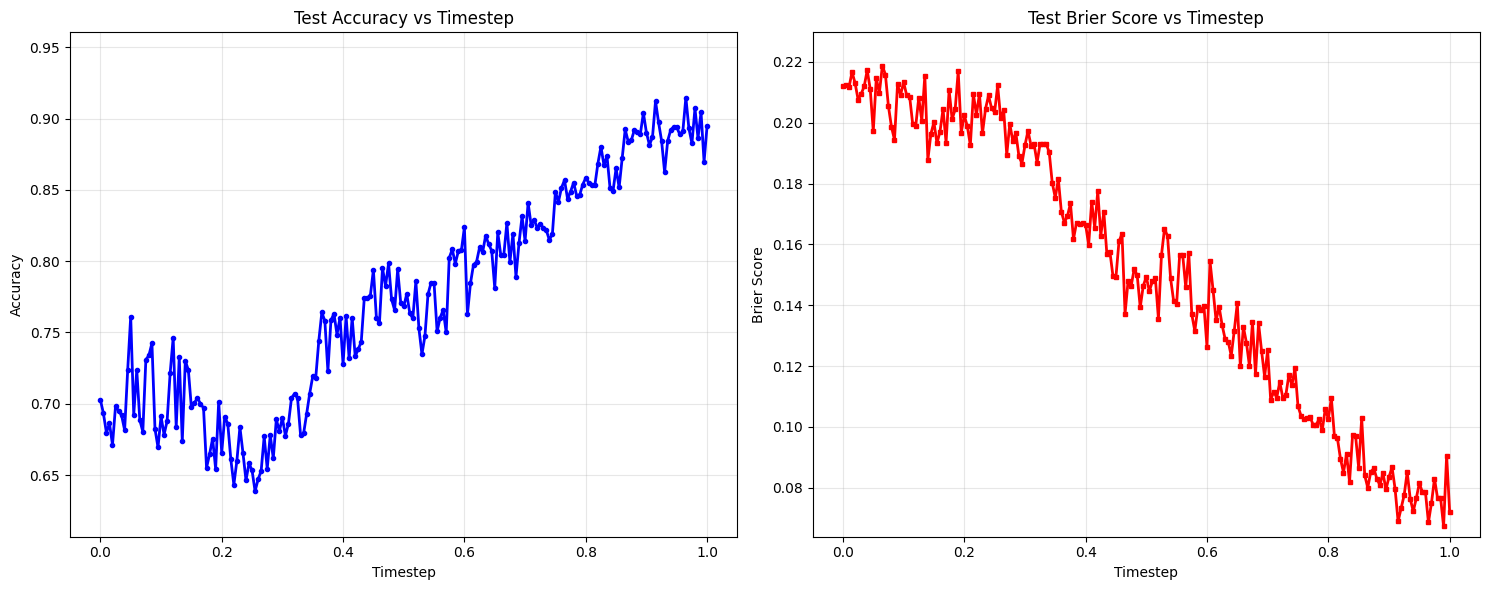


Summary Statistics:
Average Accuracy: 0.7732 ± 0.0769
Average Brier Score: 0.1501 ± 0.0466
Best Accuracy: 0.9147 at timestep 96.50%
Best Brier Score: 0.0673 at timestep 99.00%


In [33]:
# Test accuracy and Brier score of model for each timestep on test data and plot
accuracies = []
brier_scores = []
timesteps = []
def brier_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

for timestep, i in zip(ensemble_models, test_data.keys()):
    model = ensemble_models[timestep]
    # Convert test data to array
    y_test = np.array([row["label"] for row in test_data_seq[i]])
    X_test = np.array([row["rows"] for row in test_data_seq[i]])
    
    # Calculate accuracy
    accuracy = model.score(X_test, y_test)
    
    # Calculate Brier score
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]  # Get probability predictions
    brier_score = brier_loss(y_test, y_test_pred_proba)
    
    print(f"Timestep {timestep:.2%}: Accuracy = {accuracy:.4f}, Brier Score = {brier_score:.4f}")
    accuracies.append(accuracy)
    brier_scores.append(brier_score)
    timesteps.append(timestep)

# Create subplots for both metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot accuracy
ax1.plot(timesteps, accuracies, 'b-', linewidth=2, marker='o', markersize=3)
ax1.set_xlabel("Timestep")
ax1.set_ylabel("Accuracy")
ax1.set_title("Test Accuracy vs Timestep")
ax1.grid(True, alpha=0.3)
ax1.set_ylim([min(accuracies) * 0.95, max(accuracies) * 1.05])

# Plot Brier score
ax2.plot(timesteps, brier_scores, 'r-', linewidth=2, marker='s', markersize=3)
ax2.set_xlabel("Timestep")
ax2.set_ylabel("Brier Score")
ax2.set_title("Test Brier Score vs Timestep")
ax2.grid(True, alpha=0.3)
ax2.set_ylim([min(brier_scores) * 0.95, max(brier_scores) * 1.05])

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSummary Statistics:")
print(f"Average Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Average Brier Score: {np.mean(brier_scores):.4f} ± {np.std(brier_scores):.4f}")
print(f"Best Accuracy: {max(accuracies):.4f} at timestep {timesteps[np.argmax(accuracies)]:.2%}")
print(f"Best Brier Score: {min(brier_scores):.4f} at timestep {timesteps[np.argmin(brier_scores)]:.2%}")

In [35]:
model = ensemble_models[0.995]
features = ["relative_strength", "score_difference", "home_has_possession", "end.down", "end.distance", "end.yardsToEndzone",  "home_timeouts_left", "away_timeouts_left"]
data_point = [[0.5, -4, 1, 1, 1, 1, 1, 1], [0.5, -4, 1, 1, 1, 1, 1, 1], [0.5, -4, 1, 1, 1, 1, 1, 1], [0.5, -4, 1, 1, 1, 1, 1, 1], [0.5, -4, 1, 1, 1, 1, 1, 1]]
model.predict_proba(np.array([data_point]))

array([[0.80688508, 0.19311492]])

In [146]:
model = ensemble_models[0]
model.predict_proba(np.arange(110).reshape(2, 5, 11))

Model name:  xgboost
(2, 5, 11)
(2, 11)
[[0.         1.        ]
 [0.19230769 0.80769231]]
Model name:  nn
(2, 5, 11)
(2, 11)
[[1. 0.]
 [1. 0.]]
Model name:  logistic
(2, 5, 11)
(2, 11)
[[0. 1.]
 [0. 1.]]
Model name:  lstm
(2, 5, 11)
[[0.79934996 0.20065005]
 [0.7205218  0.27947822]]


array([[0.48275698, 0.51724302],
       [0.44681822, 0.55318178]])

In [20]:
# Write predictions to csv file
from process_data import write_predictions
write_predictions(ensemble_models, interpolated_dir, [2024], 4, features, replace_nan_val = 0, phat_b = "ensemble_phat_b_model")

Loading data for 2024
Processed file:  game_401671629.csv
Processed file:  game_401671601.csv
Processed file:  game_401671826.csv
Processed file:  game_401671832.csv
Processed file:  game_401671749.csv
Processed file:  game_401671775.csv
Processed file:  game_401671761.csv
Processed file:  game_401671760.csv
Processed file:  game_401671774.csv
Processed file:  game_401671748.csv
Processed file:  game_401671833.csv
Processed file:  game_401671827.csv
Processed file:  game_401671600.csv
Processed file:  game_401671628.csv
Processed file:  game_401671616.csv
Processed file:  game_401671831.csv
Processed file:  game_401671825.csv
Processed file:  game_401671819.csv
Processed file:  game_401671762.csv
Processed file:  game_401671776.csv
Processed file:  game_401671789.csv
Processed file:  game_401671788.csv
Processed file:  game_401671777.csv
Processed file:  game_401671763.csv
Processed file:  game_401671818.csv
Processed file:  game_401671824.csv
Processed file:  game_401671830.csv
Proces

In [161]:
modules_to_reload = [
    "process_data"
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]
import process_data
process_data.assess_differences(ensemble_models, test_data_seq, 0.95)

[[  0.3927 -33.       0.      -1.      10.       0.       3.       3.    ]
 [  0.3927 -33.       0.       1.      10.      70.       3.       3.    ]
 [  0.3927 -33.       1.       2.       7.      67.       3.       3.    ]
 [  0.3927 -33.       1.       2.       7.      67.       3.       3.    ]
 [  0.3927 -33.       1.       2.       7.      67.       3.       3.    ]]


ValueError: can only convert an array of size 1 to a Python scalar

In [22]:
import os
import shutil

# Define the ancestor directory and the parent directory
src_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Adjust the number of "../" as needed
dest_dir = os.path.abspath(os.path.join(os.getcwd(), "../../"))

# Specify the file or directory to copy from the ancestor directory
source = os.path.join(src_dir, "dataset_interpolated_fixed", "2024")  # Replace with the actual name
destination = os.path.join(dest_dir, "test_7", "ensemble_model_testing_2")  # Replace with the desired name

# Perform the copy operation
if os.path.exists(source):
    if os.path.isdir(source):
        shutil.copytree(source, destination)
    else:
        shutil.copy2(source, destination)
    print(f"Copied '{source}' to '{destination}'")
else:
    print(f"Source '{source}' does not exist")

Copied '/Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/NFL/ML/dataset_interpolated_fixed/2024' to '/Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/NFL/test_7/ensemble_model_testing_2'
